In [1]:
import wrds
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
import os
import pickle
warnings.filterwarnings('ignore')


# First draft - dispersion trade

require: 
1. option_name data for the names of tickers 
2. option_data for the option data and 
3. secutiry price from secprd2023

## Get secid of Indices and corresponding ETF


In [2]:
# Establish WRDS connection
db = wrds.Connection(wrds_username='changjulian17')

# Create cache directory if it doesn't exist
cache_dir = '../cache'
os.makedirs(cache_dir, exist_ok=True)

# Check if cached data exists
option_name_cache = f'{cache_dir}/option_name.csv'

if os.path.exists(option_name_cache):
    print("Loading cached option_name data...")
    option_name = pd.read_csv(option_name_cache)
else:
    print("Fetching option_name data from WRDS...")
    
    query = """
    SELECT 
        *
    FROM optionm.secnmd
    """
    
    option_name = db.raw_sql(query)
    db.close()
    
    # Cache the results
    option_name.to_csv(option_name_cache, index=False)
    print(f"Cached option_name data to {option_name_cache}")

print(f"Retrieved {len(option_name)} option records")
print(option_name.head())
option_name[option_name['ticker'] == 'SPY']

Loading library list...
Done
Loading cached option_name data...
Retrieved 265203 option records
    secid effect_date     cusip ticker class                      issuer  \
0  5001.0  1996-01-02  00078110  ABSIE   NaN          ABS INDUSTRIES INC   
1  5001.0  2007-03-08  00078110   ZZZZ   NaN                ABS INDS INC   
2  5002.0  1996-01-01  00103010  AELNA   NaN       AEL INDUSTRIES - CI A   
3  5003.0  1996-01-01  00103810   AFAP   NaN  AFA PROTECTIVE SYSTEMS INC   
4  5003.0  1999-07-08  00103810  AFAPE   NaN  AFA PROTECTIVE SYSTEMS INC   

  issue     sic  
0   NaN     NaN  
1   COM  3462.0  
2   NaN     NaN  
3   NaN     NaN  
4   NaN     NaN  


,secid,effect_date,cusip,ticker,class,issuer,issue,sic
5563,7571.0,1996-10-28,81750M10,SPY,NaN,SERENPET INC,NaN,NaN
10623,100155.0,2009-11-02,32299W10,SPY,I,SPDR TRUST SERIES 1,INTRADAY,9999.0
71921,109820.0,1996-01-02,78462F10,SPY,NaN,SPDR TR,UNIT SER 1,NaN
71922,109820.0,2000-11-28,78462F10,SPY,NaN,SPDR TR,UNIT SER 1,6726.0
71923,109820.0,2010-01-28,78462F10,SPY,NaN,SPDR S&P 500 ETF TR,UNIT SER 1 S&P,6726.0
71924,109820.0,2010-07-08,78462F10,SPY,NaN,SPDR S&P 500 ETF TR,TR UNIT,6726.0
71925,109820.0,2017-12-26,78462F10,SPY,NaN,SPDR S&P 500 ETF TR,TR UNIT,6733.0
71926,109820.0,2020-07-27,78462F10,SPY,NaN,SSGA ACTIVE TRUST,SSGA SPDR S&P 500,NaN
71927,109820.0,2021-02-25,78462F10,SPY,NaN,SSGA ACTIVE TRUST,SPDR S&P 500 ETF TRU,NaN
71928,109820.0,2021-03-01,78462F10,SPY,NaN,SSGA ACTIVE TRUST,S&P 500 ETF TRUST ET,NaN


In [3]:
# 1. Get secids for target tickers from secnmd with issuer filtering
target_tickers = ['SPY', 'XLK', 'XLY', 'XLF', 'XLV']
target_issuers = ['SPDR S&P 500 ETF TR', 'SECTOR SPDR TR', 
                  'SELECT SECTOR SPDR TR']

# Filter secnmd for target tickers AND issuers
target_securities = option_name[
    (option_name['ticker'].isin(target_tickers)) &
    (option_name['issuer'].isin(target_issuers))
]

target_secids = target_securities['secid'].tolist()

# print(f"Found {len(target_secids)} secids for target tickers and issuers:")
target_securities = target_securities[['secid', 'ticker']].drop_duplicates()
secid_list = target_securities['secid'].tolist()
secid_list

[109820.0, 110008.0, 110010.0, 110012.0, 110014.0]

## Get Option data for short listed secid

In [4]:
# Convert secids to string format for SQL IN clause
secid_list_str = ','.join([f"'{secid}'" for secid in secid_list])

# Cache option data
option_data_cache = f'{cache_dir}/filtered_option_data.pkl'

if os.path.exists(option_data_cache):
    print("Loading cached option data...")
    with open(option_data_cache, 'rb') as f:
        filtered_option_data = pickle.load(f)
else:
    print("Fetching option data from WRDS...")
    
    query = f"""
    SELECT 
        *
    FROM optionm.opprcd2023
    WHERE secid IN ({secid_list_str})
        AND date >= '2023-01-01'
        AND date <= '2023-12-31'
    ORDER BY date, secid, strike_price, cp_flag
    """
    
    filtered_option_data = db.raw_sql(query)
    db.close()
    
    # Cache the results
    with open(option_data_cache, 'wb') as f:
        pickle.dump(filtered_option_data, f)
    print(f"Cached option data to {option_data_cache}")

print(f"Retrieved {len(filtered_option_data)} option records for target secids")
print(filtered_option_data.head())

Loading cached option data...
Retrieved 2394422 option records for target secids
      secid        date             symbol symbol_flag      exdate  \
0  109820.0  2023-01-03  SPY 241220C120000           1  2024-12-20   
1  109820.0  2023-01-03  SPY 241220P120000           1  2024-12-20   
2  109820.0  2023-01-03  SPY 241220C130000           1  2024-12-20   
3  109820.0  2023-01-03  SPY 241220P130000           1  2024-12-20   
4  109820.0  2023-01-03  SPY 241220C140000           1  2024-12-20   

    last_date cp_flag  strike_price  best_bid  best_offer  ...     theta  \
0  2022-12-19       C      120000.0     260.5       265.5  ... -8.084044   
1  2023-01-03       P      120000.0      0.99        1.16  ... -1.457403   
2  2022-10-17       C      130000.0     251.5       256.5  ... -9.233222   
3  2022-12-29       P      130000.0       0.0        1.35  ... -0.995745   
4        <NA>       C      140000.0     242.5       247.5  ... -10.00525   

      optionid  cfadj  am_settlement  con

## Get the ETF OCHL (Open Close High Low)

In [5]:
# Cache security price data
security_data_cache = f'{cache_dir}/security_data.csv'

if os.path.exists(security_data_cache):
    print("Loading cached security price data...")
    security_data = pd.read_csv(security_data_cache, parse_dates=['date'])
else:
    print("Fetching security price data from WRDS...")
    db = wrds.Connection(wrds_username='changjulian17')
    
    query = f"""
    SELECT 
        *
    FROM optionm.secprd2023
    WHERE secid IN ({secid_list_str})
        AND date >= '2023-01-01'
        AND date <= '2023-12-31'
    """
    
    security_data = db.raw_sql(query)
    db.close()
    
    # Cache the results
    security_data.to_csv(security_data_cache, index=False)
    print(f"Cached security data to {security_data_cache}")

print(f"Retrieved {len(security_data)} security price records")
print(security_data.head())

Loading cached security price data...
Retrieved 835 security price records
      secid       date       low    high   close       volume    return  \
0  109820.0 2023-01-03  377.8310  386.43  380.82   74850731.0 -0.004210   
1  109820.0 2023-01-04  380.0000  385.88  383.76   85934098.0  0.007720   
2  109820.0 2023-01-05  378.7600  381.84  379.38   76970456.0 -0.011413   
3  109820.0 2023-01-06  379.4127  389.25  388.08  104189603.0  0.022932   
4  109820.0 2023-01-09  387.6700  393.70  387.86   73978071.0 -0.000567   

   cfadj    open    cfret    shrout  
0    1.0  384.37  1.62005  932632.0  
1    1.0  383.18  1.62005  932632.0  
2    1.0  381.72  1.62005  927282.0  
3    1.0  382.61  1.62005  931982.0  
4    1.0  390.37  1.62005  929682.0  


In [6]:
security_data['secid'].unique()

array([109820., 110008., 110010., 110012., 110014.])

In [7]:
# Add ticker mapping to security data
secid_ticker_mapping = target_securities.set_index('secid')['ticker'].to_dict()
security_data['ticker'] = security_data['secid'].map(secid_ticker_mapping)

# Calculate average close price for each security
# ensure to only take mean dates for test period before 1 July 2023
cutoff_date = pd.to_datetime('2023-02-01')
security_data_before_july = security_data[security_data['date'] < cutoff_date]

avg_close_prices = security_data_before_july.groupby(['secid', 'ticker'])['close'].mean().reset_index()
avg_close_prices.columns = ['secid', 'ticker', 'avg_close']
avg_close_prices

,secid,ticker,avg_close
0,109820.0,SPY,394.6960
1,110008.0,XLV,134.1395
2,110010.0,XLY,138.3150
3,110012.0,XLF,35.5800
4,110014.0,XLK,130.0410


## Basic calculations 
assumed proportion (27 July 2025), estimated and scaled proportions:

| Sector                 | Ticker | Assumed Proportion | Estimated (%) | Scaled (%) |
| ---------------------- | ------ | ------------------ | ------------- | ---------- |
| Technology             | XLK    | 34.36%             | 30%           | 42.857%    |
| Financial Services     | XLF    | 13.67%             | 10%           | 14.2857%   |
| Consumer Cyclical      | XLY    | 10.54%             | 10%           | 14.2857%   |
| Communication Services | XLC    | 9.79%              | 10%           | 14.2857%   |
| Healthcare             | XLV    | 9.33%              | 10%           | 14.2857%   |

*won't be too exact since it is a snapshot and it should change over time too

show the market cap and implied notional for all components

SPY: 384.37\
XLK: 125.77\
XLV: 135.96\
XLY: 129.93\
XLF: 34.45

## Fundamental assumption
Volitility of S index is much lower than C component.
$$
{IV}_S \le \sum{{IV}_i}
$$
SPY should be represented by a proportionate constituents of sector ETF. Also so that the IV can be easily comparable i.e. 1 unit of SPY vol is comparable with one basket of C vol

$$
S_0 \times Q_0 = \sum{{C_i} \times Q_i} 
$$

Need to calculate delta as the scaling factor to get proportion of purchase of stocks.

Assumption
1. take only top 4 sectors of SPY and scale up to 100% of SPY give n by (scaled_weights)
2. fix the proportion of 4 sectors 


In [8]:
scaled_weights = {
    "SPY": 100,
    "XLK": 42.857,
    "XLF": 14.2857,
    "XLY": 14.2857,
    "XLC": 14.2857,
    "XLV": 14.2857
}

avg_close_prices['Scaled_Weight'] = avg_close_prices['ticker'].map(scaled_weights)
# Calculate relative position sizes
# coefficients = weights / prices * scaling_factor
vector = avg_close_prices['Scaled_Weight'].values / avg_close_prices['avg_close'].values * 20
vector_rounded = np.round(vector).astype(int)
# trial and error on the scaling factor to find a nice association
avg_close_prices['Vector (Scaled_Weight)'] = vector_rounded
avg_close_prices

,secid,ticker,avg_close,Scaled_Weight,Vector (Scaled_Weight)
0,109820.0,SPY,394.6960,100.0000,5
1,110008.0,XLV,134.1395,14.2857,2
2,110010.0,XLY,138.3150,14.2857,2
3,110012.0,XLF,35.5800,14.2857,8
4,110014.0,XLK,130.0410,42.8570,7


In [9]:
# Function to check if a date is the 3rd Friday of the month
def is_third_friday(date):
    return date.weekday() == 4 and 15 <= date.day <= 21

# Find ATM strikes for each option based on previous day's close
simplified_cols = ['secid', 'date', 'symbol', 'exdate', 
                     'cp_flag', 'strike_price', 'best_bid', 'best_offer',
                     'impl_volatility']

# 1. Prepare previous day's close for each secid/date
security_data_sorted = security_data.sort_values(['secid', 'date'])
security_data_sorted['prev_close'] = security_data_sorted.groupby('secid')['close'].shift(1)

# 2. Merge previous day's close into option data
filtered_option_data = filtered_option_data[simplified_cols]
# filter non-regular options
filtered_option_data['exdate'] = pd.to_datetime(filtered_option_data['exdate'])
filtered_option_data['date'] = pd.to_datetime(filtered_option_data['date'])

# Filter for rows where exdate is the 3rd Friday of the month and within the first/last exdate range
filtered_option_data = filtered_option_data[
    filtered_option_data['exdate'].apply(is_third_friday) &
    (filtered_option_data['exdate'] >= filtered_option_data['exdate'].min()) &
    (filtered_option_data['exdate'] <= filtered_option_data['exdate'].max())
]

filtered_option_data = filtered_option_data.merge(
    security_data_sorted[['secid', 'date', 'prev_close']],
    on=['secid', 'date'],
    how='left'
)

# Calculate the absolute difference between strike and previous close
filtered_option_data['abs_diff'] = np.abs(filtered_option_data['strike_price']/1000 - filtered_option_data['prev_close'])

# Find the ATM strike for each secid, date, cp_flag
atm_strike_idx = filtered_option_data.groupby(['secid', 'date', 'cp_flag'])['abs_diff'].idxmin().dropna()
atm_strikes = filtered_option_data.loc[atm_strike_idx, ['secid', 'date', 'cp_flag', 'strike_price']]
atm_strikes = atm_strikes.rename(columns={'strike_price': 'atm_strike_price'})

# Merge the ATM strike back to the original DataFrame
filtered_option_data = filtered_option_data.merge(
    atm_strikes,
    on=['secid', 'date', 'cp_flag'],
    how='left'
)
filtered_option_data['ticker'] = filtered_option_data['secid'].map(secid_ticker_mapping)


filtered_option_data = filtered_option_data.dropna(subset=['atm_strike_price'])

In [10]:
filtered_option_data.exdate.unique()

<DatetimeArray>
['2024-12-20 00:00:00', '2023-03-17 00:00:00', '2023-06-16 00:00:00',
 '2023-09-15 00:00:00', '2023-02-17 00:00:00', '2025-12-19 00:00:00',
 '2023-12-15 00:00:00', '2023-04-21 00:00:00', '2023-01-20 00:00:00',
 '2025-03-21 00:00:00', '2024-01-19 00:00:00', '2025-01-17 00:00:00',
 '2024-06-21 00:00:00', '2023-10-20 00:00:00', '2023-05-19 00:00:00',
 '2023-07-21 00:00:00', '2024-03-15 00:00:00', '2023-08-18 00:00:00',
 '2024-09-20 00:00:00', '2025-06-20 00:00:00', '2023-11-17 00:00:00',
 '2024-04-19 00:00:00']
Length: 22, dtype: datetime64[ns]

In [28]:
def calculate_dispersion_ivs(df, avg_close_prices, trade_date, exdate_target, fudge_factor=2, vector_rounded=None):
    """
    Calculate SPY and basket implied volatilities and their difference for a given trade_date and exdate_target.
    Returns a tuple: (spy_iv, basket_iv, spread)
    """
    df = filtered_option_data[filtered_option_data['exdate'] == exdate_target]
    # Find ATM strike for each secid, date, cp_flag
    atm_strike_idx = df.groupby(['secid', 'date', 'cp_flag'])['abs_diff'].idxmin().dropna()
    atm_strikes = df.loc[atm_strike_idx, ['secid', 'date', 'cp_flag', 'strike_price']]
    atm_strikes = atm_strikes.rename(columns={'strike_price': 'atm_strike_price'})

    # Remove old atm_strike_price if present, then merge new
    df = df.drop(columns=['atm_strike_price'], errors='ignore')
    df['bid'] = df['best_bid'] - fudge_factor * (df['best_offer'] - df['best_bid'])
    df['ask'] = df['best_offer'] + fudge_factor * (df['best_offer'] - df['best_bid'])
    df = df.merge(
        atm_strikes,
        on=['secid', 'date', 'cp_flag'],
        how='left'
    )

    df = df.drop(columns=['Vector (Scaled_Weight)'], errors='ignore')
    df = df.merge(
        avg_close_prices[['ticker', 'Vector (Scaled_Weight)']],
        on='ticker',
        how='left'
    )
    # calculate spy iv
    spy_iv = df[(df['ticker'] == 'SPY') &
                (df['date'] == trade_date) &
                (df['strike_price'] == df['atm_strike_price'])]['impl_volatility'].mean()

    # calculate basket iv
    df_1 = df[(df['ticker'] != 'SPY') &
              (df['date'] == trade_date) &
              (df['strike_price'] == df['atm_strike_price'])].copy()
    # print(df.head(), df_1.head())
    df_1['weighted_iv'] = df_1['impl_volatility'] * df_1['Vector (Scaled_Weight)']
    basket_iv =df_1[(df_1['ticker'] != 'SPY') &
            (df_1['date'] == trade_date) &
            (df_1['strike_price'] == df_1['atm_strike_price'])
            ].groupby('ticker')['weighted_iv'].mean().sum() / vector_rounded.sum()

    spread = basket_iv - spy_iv
    return spy_iv, basket_iv, spread

# Example usage:
spy_iv, basket_iv, spread = calculate_dispersion_ivs(filtered_option_data, 
                                                     avg_close_prices, 
                                                     trade_date, 
                                                     exdate_target, 
                                                     fudge_factor=2, 
                                                     vector_rounded=vector_rounded)
print(f"spy iv: {spy_iv}, basket iv: {basket_iv},ratio: {spread}")

spy iv: 0.2051595, basket iv: 0.18776472916666667,ratio: -0.017394770833333323


In [17]:
trade_date, exdate_target

(Timestamp('2023-01-31 00:00:00'), Timestamp('2023-02-17 00:00:00'))

In [ ]:
df[(df['ticker'] != 'SPY') &
       (df['date'] == trade_date) &
       (df['strike_price'] == df['atm_strike_price'])]

,secid,date,symbol,exdate,cp_flag,strike_price,best_bid,best_offer,impl_volatility,prev_close,abs_diff,ticker,bid,ask,atm_strike_price,Vector (Scaled_Weight)
18348,110008.0,2023-01-31,XLV 230217C131500,2023-02-17,C,131500.0,3.0,3.15,0.161903,131.66,0.16,XLV,2.7,3.45,131500.0,2
18349,110008.0,2023-01-31,XLV 230217P131500,2023-02-17,P,131500.0,0.99,1.05,0.164632,131.66,0.16,XLV,0.87,1.17,131500.0,2
18560,110010.0,2023-01-31,XLY 230217C145000,2023-02-17,C,145000.0,5.95,6.2,0.304368,145.37,0.37,XLY,5.45,6.7,145000.0,2
18561,110010.0,2023-01-31,XLY 230217P145000,2023-02-17,P,145000.0,2.18,2.36,0.308407,145.37,0.37,XLY,1.82,2.72,145000.0,2
18664,110012.0,2023-01-31,XLF 230217C36000,2023-02-17,C,36000.0,0.98,0.99,0.201304,36.07,0.07,XLF,0.96,1.01,36000.0,8
18665,110012.0,2023-01-31,XLF 230217P36000,2023-02-17,P,36000.0,0.36,0.37,0.199994,36.07,0.07,XLF,0.34,0.39,36000.0,8
18828,110014.0,2023-01-31,XLK 230217C134000,2023-02-17,C,134000.0,4.35,4.55,0.278779,134.09,0.09,XLK,3.95,4.95,134000.0,7
18829,110014.0,2023-01-31,XLK 230217P134000,2023-02-17,P,134000.0,2.24,2.36,0.28175,134.09,0.09,XLK,2.0,2.6,134000.0,7


In [ ]:
# At entry, basket is bought at ask, weighted by Vector (Scaled_Weight)
(
    df[(df['ticker'] != 'SPY') &
       (df['date'] == trade_date) &
       (df['strike_price'] == df['atm_strike_price'])]
    .assign(weighted_ask=lambda x: x['ask'] * x['Vector (Scaled_Weight)'])['weighted_ask']
    .sum()
)

np.float64(92.13)

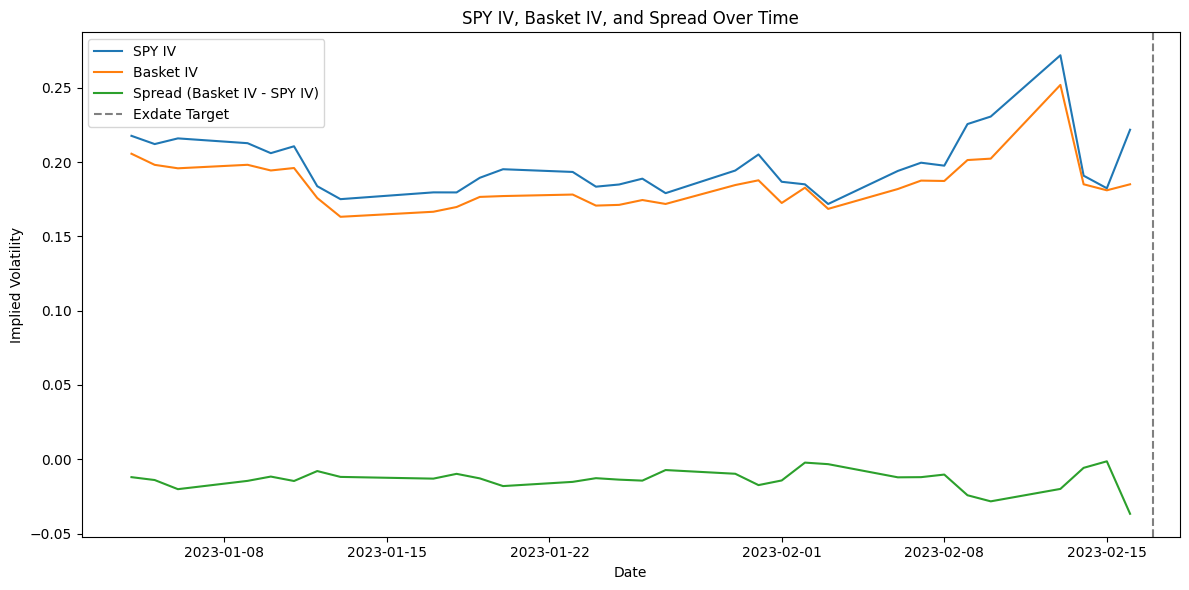

In [ ]:
import matplotlib.pyplot as plt

# Prepare time series for SPY IV, basket IV, and spread
dates = sorted(df['date'].unique())
spy_iv_series = []
basket_iv_series = []

for d in dates:
    # SPY IV
    spy_iv = df[
        (df['ticker'] == 'SPY') &
        (df['date'] == d) &
        (df['strike_price'] == df['atm_strike_price'])
    ]['impl_volatility'].mean()
    # Basket IV
    df_basket = df[
        (df['ticker'] != 'SPY') &
        (df['date'] == d) &
        (df['strike_price'] == df['atm_strike_price'])
    ].copy()
    df_basket['weighted_iv'] = df_basket['impl_volatility'] * df_basket['Vector (Scaled_Weight)']
    basket_iv = df_basket.groupby('ticker')['weighted_iv'].mean().sum() / vector_rounded.sum()
    spy_iv_series.append(spy_iv)
    basket_iv_series.append(basket_iv)

# Convert to pandas Series for robust NA handling
dates_arr = pd.to_datetime(pd.Series(dates))
spy_iv_arr = pd.to_numeric(pd.Series(spy_iv_series), errors='coerce')
basket_iv_arr = pd.to_numeric(pd.Series(basket_iv_series), errors='coerce')
spread_arr = basket_iv_arr - spy_iv_arr

# Mask out dates where either series is nan or NAType
valid_mask = ~(spy_iv_arr.isna() | basket_iv_arr.isna())
dates_plot = dates_arr[valid_mask]
spy_iv_plot = spy_iv_arr[valid_mask]
basket_iv_plot = basket_iv_arr[valid_mask]
spread_plot = spread_arr[valid_mask]

plt.figure(figsize=(12, 6))
plt.plot(dates_plot, spy_iv_plot, label='SPY IV')
plt.plot(dates_plot, basket_iv_plot, label='Basket IV')
plt.plot(dates_plot, spread_plot, label='Spread (Basket IV - SPY IV)')
plt.axvline(pd.to_datetime(exdate_target), color='gray', linestyle='--', label='Exdate Target')
plt.xlabel('Date')
plt.ylabel('Implied Volatility')
plt.title('SPY IV, Basket IV, and Spread Over Time')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def build_dispersion_trade(df, trade_date, exdate_target, vector_col='Vector (Scaled_Weight)'):
    """
    For a given exdate_target and trade_date, returns a DataFrame with trade instructions:
    - Sell 5 SPY ATM straddles (5 calls + 5 puts)
    - Buy basket ETF ATM straddles according to Vector (Scaled_Weight)
    """
    trade_list = []
    # Sell 5 SPY ATM straddles (calls and puts)
    for cp_flag in ['C', 'P']:
        spy_row = df[
            (df['ticker'] == 'SPY') &
            (df['date'] == trade_date) &
            (df['exdate'] == exdate_target) &
            (df['strike_price'] == df['atm_strike_price']) &
            (df['cp_flag'] == cp_flag)
        ]
        if not spy_row.empty:
            trade_list.append({
                'ticker': 'SPY',
                'cp_flag': cp_flag,
                'action': 'SELL',
                'contracts': 5,
                'strike': spy_row.iloc[0]['atm_strike_price'],
                'exdate': exdate_target
            })
    # Buy basket ETF ATM straddles according to vector
    basket_tickers = [t for t in df['ticker'].unique() if t != 'SPY']
    for ticker in basket_tickers:
        contracts = int(df[df['ticker'] == ticker][vector_col].iloc[0])
        for cp_flag in ['C', 'P']:
            etf_row = df[
                (df['ticker'] == ticker) &
                (df['date'] == trade_date) &
                (df['exdate'] == exdate_target) &
                (df['strike_price'] == df['atm_strike_price']) &
                (df['cp_flag'] == cp_flag)
            ]
            if not etf_row.empty and contracts > 0:
                trade_list.append({
                    'ticker': ticker,
                    'cp_flag': cp_flag,
                    'action': 'BUY',
                    'contracts': contracts,
                    'strike': etf_row.iloc[0]['atm_strike_price'],
                    'exdate': exdate_target
                })
    return pd.DataFrame(trade_list)

# Example usage:
trade_instructions = build_dispersion_trade(df, pd.Timestamp('2023-01-31'), pd.Timestamp('2023-02-17'))

In [ ]:
import yfinance as yf

opt = yf.Ticker("XLF").option_chain("2025-08-22")
print(opt.calls.head())

       contractSymbol             lastTradeDate  strike  lastPrice  bid  ask  \
0  XLF250822C00046500 2025-07-28 18:47:32+00:00    46.5       6.71  0.0  0.0   
1  XLF250822C00047000 2025-07-21 18:44:24+00:00    47.0       6.03  0.0  0.0   
2  XLF250822C00047500 2025-07-21 18:44:24+00:00    47.5       5.55  0.0  0.0   
3  XLF250822C00048000 2025-08-01 15:28:04+00:00    48.0       3.50  0.0  0.0   
4  XLF250822C00049000 2025-07-25 20:01:51+00:00    49.0       4.67  0.0  0.0   

   change  percentChange  volume  openInterest  impliedVolatility  inTheMoney  \
0     0.0            0.0     1.0             1            0.00001        True   
1     0.0            0.0     NaN             1            0.00001        True   
2     0.0            0.0     NaN             1            0.00001        True   
3     0.0            0.0     4.0             6            0.00001        True   
4     0.0            0.0     2.0             1            0.00001        True   

  contractSize currency  
0     